In [0]:
%%capture
#Installs
!pip install -U torch torchvision transformers fast-bert fastai GPUtil
!sudo apt-get install python3.6-gdbm


In [2]:
!pip install git+https://github.com/fastai/fastai --upgrade

  Cloning https://github.com/fastai/fastai to /tmp/pip-req-build-oypz73i6
  Running command git clone -q https://github.com/fastai/fastai /tmp/pip-req-build-oypz73i6
  Created wheel for fastai: filename=fastai-1.0.61.dev0-cp36-none-any.whl size=237830 sha256=fcea242a4860479e051365895ddab9870b8a16801774c6b19dc54ce5d21abab7
  Stored in directory: /tmp/pip-ephem-wheel-cache-_2yswl4r/wheels/83/30/a0/6fa8a74c9f5a5ab45cdc84e9f9ed56d8a72750e11ebf50a364
Successfully built fastai
  Found existing installation: fastai 1.0.60
    Uninstalling fastai-1.0.60:
      Successfully uninstalled fastai-1.0.60


In [3]:
from google.colab import drive
import pandas as pd
import numpy as np
import fastai
from fastai.text import * 
from fastai.basics import *
from fastai.callbacks import * 
from fastai.callbacks.mem import PeakMemMetric
from fastai.callbacks.misc import StopAfterNBatches
from transformers import RobertaForMaskedLM, RobertaTokenizer, RobertaConfig
from transformers import XLNetLMHeadModel, XLNetTokenizer, XLNetConfig
from transformers import AdamW
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from torch.nn import CrossEntropyLoss
from fast_bert.modeling import RobertaForMultiLabelSequenceClassification, XLNetForMultiLabelSequenceClassification, BertForMultiLabelSequenceClassification
from sklearn.metrics import accuracy_score,precision_recall_fscore_support, f1_score, classification_report
from sklearn.model_selection import ShuffleSplit
from pathlib import Path
import torch
import GPUtil


drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

Classifier batch sizes that fit in cuda mem:  
roberta - 56  
xlnet - 45 barely fits (can train with unfrozen weights for 1 epoch) so using 


In [0]:
#@title Magic Panel
is_overall = True #@param {type:"boolean"}
m_type = "roberta" #@param ["roberta", "xlnet"] 
model_names = {"bert":"bert-base-cased","roberta":"distilroberta-base","xlnet":"xlnet-base-cased"}
seed = 1 #@param {type:"integer"}
pretrained_model_name = model_names[m_type]
ul_bs = 44 #@param {type:"slider", min:0, max:1000, step:1}
l_bs = 4 #@param {type:"slider", min:0, max:1000, step:1}
wd = 0.001 #@param {type:"slider", min:0, max:1, step:0.0001}

#double as due to output paraphrase taken as input
total_ul_bs = 2*ul_bs
total_bs = total_ul_bs + l_bs

In [0]:
path = Path("/content/drive/My Drive/affconsharedtask/")
labeled_comments = pd.read_csv(path / "labeled_cleaned.csv")
unlabeled_comments = pd.read_csv(path / "unlabeled_cleaned.csv")
unlabeled_para = pd.read_csv(path / "unlabeled_sent_para.txt",delimiter='\n',names=["full_text"],header=None,quoting=3)

categories = ['emotional_disclosure','information_disclosure','general_support','info_support','emo_support']
overall_categories = ['support','disclosive']



In [0]:
ul_len = len(unlabeled_para)
l_len = len(labeled_comments)

In [12]:
#unlabeled combined dataframe
ul_comb_df = unlabeled_para[['full_text']].append(unlabeled_comments[['full_text']],ignore_index=True,sort=False)
ul_comb_df = ul_comb_df.reindex(columns=list(ul_comb_df.columns.values)+(overall_categories if is_overall else categories))
ul_comb_df = ul_comb_df.fillna(-1)
ul_comb_df.tail()

,full_text,support,disclosive
835159,Understanding others is a hobby of mine.,-1.0,-1.0
835160,I so my best to understand others and empathiz...,-1.0,-1.0
835161,And as much as I want to be alone try to keep ...,-1.0,-1.0
835162,"I have to be more important, but others are st...",-1.0,-1.0
835163,"I believe so, I just started it last week and ...",-1.0,-1.0


In [0]:
ul_comb_df.shape,unlabeled_para.shape

((208792, 3), (104396, 1))

In [0]:


MODEL_CLASSES = {
    'xlnet': (XLNetLMHeadModel, XLNetForMultiLabelSequenceClassification, XLNetTokenizer, XLNetConfig),
    'roberta': (RobertaForMaskedLM, RobertaForMultiLabelSequenceClassification, RobertaTokenizer, RobertaConfig),
}
    


lm_class, model_class, tokenizer_class, config_class = MODEL_CLASSES[m_type]


In [0]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the special tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]
        
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = m_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [0]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums)
        nums[nums==-1] = self.tokenizer.mask_token_id
        nums = nums.tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)


In [0]:

transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, 
                                       include_bos=False, 
                                       include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

####Debug

In [0]:
temp = Tensor([[0.8,0.2,0.1],[0.7,0.5,0.4]])
torch.cat([temp,1-temp],dim=1).view(-1,2,temp.shape[-1])


tensor([[[0.8000, 0.2000, 0.1000],
         [0.2000, 0.8000, 0.9000]],

        [[0.7000, 0.5000, 0.4000],
         [0.3000, 0.5000, 0.6000]]])

###Unsupervised Data Augmentation 

plan:   
custom sampler for dataloader to make each batch be labeled stuff first then unlabeled stuff, which will be 2 SortishSampler wrapped by BatchSampler both wrapped by the custom sampler

hacky modification: load the unlabeled augmented as a part of input to appease fastai format, then format correctly when sampling

custom collate function to split data into labeled and unlabeled and pad

custom loss: calculate loss separately for the unlabeled and labeled  
Training signal annealling: implement as callback on_loss_begin to filter supervised examples that are over the confidence rate



Forgot our problem is multilabel so gonna see if 

####Custom Sampler

In [0]:
class UDABatchSampler(Sampler):

    def __init__(self, l_sampler, ul_sampler, l_len, ul_len):
        self.l_sampler = l_sampler
        self.ul_sampler = ul_sampler
        self.l_len=l_len
        self.ul_len=ul_len

    
    #samplers will return indices from 0...n so need to offset each set of batch indices appropriately
    
    def __iter__(self):
        for l_b,ul_b in zip(self.l_sampler,self.ul_sampler):
            ul_b =[x + self.l_len for x in ul_b]
            ul_ori_b = [x + self.ul_len for x in ul_b]
            yield l_b+ul_b+ul_ori_b

    def __len__(self):
        return min(len(self.l_sampler),len(self.ul_sampler))




####Custom Collate


In [0]:
def uda_pad_collate(samples:BatchSamples, l_bs:int, ul_bs:int, pad_idx:int=1, pad_first:bool=True, backwards:bool=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len = max([len(s[0]) for s in samples])
    res = torch.zeros(len(samples), max_len).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: res[i,-len(s[0]):] = LongTensor(s[0])
        else:         res[i,:len(s[0]):] = LongTensor(s[0])
    if backwards: res = res.flip(1)
    res, ul_ori = res.split([len(samples)-ul_bs,ul_bs])
    labels = tensor(np.array([s[1] for s in samples[:l_bs]]))
    return res, (labels, ul_ori)
    

####Custom Loss

In [0]:
class UDALoss(Module):

    def __init__(self, ori_loss_func, lambd=1):
        self.lambd = lambd
        self.sup_loss_func = ori_loss_func
        self.unsup_loss_func = nn.KLDivLoss(reduction='batchmean')


    
    def forward(self, inputs, targets):
        if(len(inputs)!=4):
            return self.sup_loss_func(inputs,targets)
        l_logits, ul_logits, l_mask, ori_preds = inputs
        targets = targets[0]
        #use softplus for numerical stability following the tensorflow implementation
        ul_logprobs = nn.Softplus(beta=-1)(ul_logits)
        #log(1-p) = log(p) - log(1/(1-p))
        ul_loginvprobs = ul_logprobs - ul_logits
        ul_dist = torch.cat([ul_logprobs,ul_loginvprobs],dim=1).view(-1,2,ul_logits.shape[-1])
        del ul_logprobs,ul_loginvprobs,ul_logits
        #print(targets.shape,ul_ori.shape,l_logits.shape,ul_logits.shape,l_mask.shape)
        #print(targets.type(),ul_ori.type(),l_logits.type(),ul_logits.type(),l_mask.type())
        #print(l_mask)
        #print(targets[l_mask.bool(),:])

        #using mean for reduction will divide by number of elements in tensor, but we want the average of every matching pair of prediction probs. so *2
        unsup_loss = self.unsup_loss_func(ul_dist, ori_preds)/l_logits.shape[1]
        total_loss = self.lambd*unsup_loss
        
        #print(unsup_loss)
        del unsup_loss,ul_dist
        if(l_logits.numel()!=0):
            sup_loss = self.sup_loss_func(l_logits,targets[l_mask.bool(),:])
            total_loss += sup_loss
            #print(sup_loss)
            del sup_loss
            
        
        return total_loss

####Custom Callback



*   despite the name of on_train_begin(), it runs before validation as well
*   on_batch_begin is when the train flag updates, where the flag is true when training and false when validating



In [0]:
class UDACallback(LearnerCallback):
    
    def __init__(self,learn:Learner, ul_len:int, l_len:int, ul_bs:int, l_bs:int, tsa_sched:str='log', lambd:int=1, pad_idx:int=1, pad_first:bool=True, backwards:bool=False):
        super().__init__(learn)
        self.ul_len=ul_len
        self.l_len=l_len
        self.ul_bs=ul_bs
        self.l_bs=l_bs
        self.tsa_sched=tsa_sched
        self.lambd=lambd
        self.pad_idx=pad_idx
        self.pad_first=pad_first
        self.backwards=backwards

    def on_train_begin(self, **kwargs):
        
        self.learn.loss_func = UDALoss(self.learn.loss_func, self.lambd)
        train_ds = self.learn.data.train_dl.dl.dataset
        sort_key = lambda t: len(train_ds[t][0].data)
        l_sampler = BatchSampler(SortishSampler(train_ds.x[:self.l_len],key=sort_key,bs=l_bs),batch_size=l_bs,drop_last=True)
        ul_sampler = BatchSampler(SortishSampler(train_ds.x[self.l_len:self.l_len+self.ul_len],key=sort_key,bs=ul_bs),batch_size=ul_bs,drop_last=True)
        uda_sampler = UDABatchSampler(l_sampler,ul_sampler,l_len=self.l_len,ul_len=self.ul_len)
        self.learn.data.train_dl = self.learn.data.train_dl.new(sampler=None, shuffle=False, batch_sampler=uda_sampler,batch_size=1,drop_last=False)
        self.learn.data.train_dl.dl.collate_fn = partial(uda_pad_collate, ul_bs=self.ul_bs, l_bs=self.l_bs, pad_idx=self.pad_idx, pad_first=self.pad_first, backwards=self.backwards)

    def on_batch_begin(self, last_input:Tensor, last_target:Tensor, train:bool, **kwargs): 
        if(train):
            return {'last_target': ((last_target[0],last_target[1].long()),)}
        
    def on_batch_end(self, iteration:int=0, **kwargs):
        if(iteration%500==0):
            GPUtil.showUtilization()
            gc.collect()
            torch.cuda.empty_cache()
            GPUtil.showUtilization()
            
        return
        
        
    def on_loss_begin(self, train:bool, last_target, last_output:Tensor, iteration:int=0, n_epochs:int=0, epoch:int=0, **kwargs):
        if(not train):
            return
        
        l_logits, ul_logits = last_output.split([self.l_bs,self.ul_bs])
        #print(l_logits)
        with torch.no_grad():
            preds = torch.sigmoid(l_logits) #shape: (N , 2)
            thresh = self._tsa_thresh(preds.shape[1],(iteration+1)%len(self.learn.data.train_dl)+epoch*len(self.learn.data.train_dl),len(self.learn.data.train_dl)*n_epochs)
            
            #if any of the predicted quantities are further from target than 1-thresh, keep the example
            mask = ((last_target[0][0]-preds).abs()>=1.0-thresh).all(dim=1)
            
            del preds,thresh
            self.learn.model.eval()
            ori_logits = self.learn.model(last_target[0][1]) 
            self.learn.model.train()
            ori_preds = torch.sigmoid(ori_logits.float())
            ori_preds = torch.cat([ori_preds,1-ori_preds],dim=1).view(-1,2,ori_preds.shape[-1])
            del ori_logits
            #print(mask,mask.type())
       
        return {'last_output': [l_logits[mask,:],ul_logits,mask,ori_preds]}


    def _tsa_thresh(self, K:int, t:int, T:int):
        if(self.tsa_sched == 'log'):
            alpha = 1 - np.exp(-5*t/T)
        elif(self.tsa_sched == 'linear'):
            alpha = t/T
        elif(self.tsa_sched == 'exp'):
            alpha = np.exp(5*(-1+t/T))
        return alpha*(1-1/K)+1/K


In [0]:
from torch.cuda import memory_stats
torch.cuda.memory_stats()

###Define Databunch

In [21]:
pad_first = bool(m_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

unlabeled_txtlist = TextList.from_df(ul_comb_df, path, cols='full_text', processor=transformer_processor)
rs = ShuffleSplit(n_splits=1, test_size=.1, random_state=seed)
train_idx,valid_idx = next(rs.split(labeled_comments))
databunch = (TextList.from_df(labeled_comments[['full_text']+overall_categories if is_overall else categories], path, cols='full_text', processor=transformer_processor)
             .add(unlabeled_txtlist)
             .split_by_idx(valid_idx)
             .label_from_df(cols=overall_categories if is_overall else categories)
             .databunch(bs=total_bs, pad_first=pad_first, pad_idx=pad_idx))

del unlabeled_txtlist


In [0]:
class CustomTransformerModel(nn.Module):
  
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids):
        # Return only the logits from the transfomer
         
        #print(logits.shape)  
        return self.transformer(input_ids)[0] 
    
    def reset(self): pass

### Training 

In [0]:
del databunch

In [0]:

del custom_transformer_model



del f_beta
del learner



In [100]:
gc.collect()
#learner.destroy()
torch.cuda.empty_cache()
!nvidia-smi

Thu Jan 23 06:21:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    36W / 250W |    725MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [28]:
!nvidia-smi

Thu Jan 23 01:02:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    35W / 250W |   1891MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
torch.cuda.empty_cache()

In [0]:
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size(), obj.is_cuda)
    except: pass
        

In [0]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = len(overall_categories) if is_overall else len(categories)
#path/'roberta-lm' for pretrained lm, pretrained_model_name otherwise
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)
del config
del transformer_model

In [0]:
f_beta = MultiLabelFbeta(beta=1,thresh=0.5)

uda_callback = partial(UDACallback,ul_len=ul_len,l_len=len(databunch.train_ds)-ul_len*2,ul_bs=ul_bs,l_bs=l_bs,pad_first=pad_first, pad_idx=pad_idx, tsa_sched='log')


#loss here defaults to Binary Cross Entropy on logits as we supply multi-labeled data
learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = lambda input: AdamW(input, correct_bias=False, weight_decay=wd), 
                  metrics=[accuracy,accuracy_thresh,f_beta],
                  callback_fns=[PeakMemMetric,uda_callback]).to_fp16()
del uda_callback


In [0]:
learner.callbacks.append(StopAfterNBatches(n_batches=1000))

In [0]:
xln_layer_list=[]
'''
xln_layer_list=[learner.model.transformer.transformer.word_embedding]
xln_layer_list.extend([i for i in learner.model.transformer.transformer.layer])
xln_layer_list.append(learner.model.transformer.sequence_summary)
'''
rb_layer_list = []
rb_layer_list=[learner.model.transformer.roberta.embeddings]
rb_layer_list.extend([i for i in learner.model.transformer.roberta.encoder.layer])
rb_layer_list.append(learner.model.transformer.roberta.pooler)
b_layer_list=[]
'''
b_layer_list=[learner.model.transformer.bert.embeddings]
b_layer_list.extend([i for i in learner.model.transformer.bert.encoder.layer])
b_layer_list.append(learner.model.transformer.bert.pooler)
'''
layer_lists = {"roberta":rb_layer_list,"bert":b_layer_list,"xlnet":xln_layer_list}
layer_list = layer_lists[m_type]

In [0]:
learner.split(layer_list)
num_groups = len(learner.layer_groups)


####Gradual Unfreezing

Seems to have no real effect on the metrics so will just train directly

In [0]:
learner.freeze() #doesnt freeze classifier

AssertionError: ignored

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-04
Min loss divided by 10: 1.10E-03


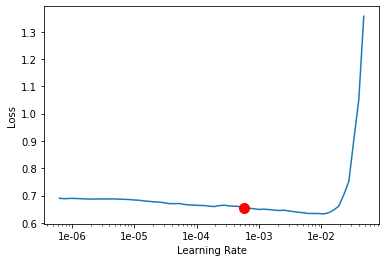

In [0]:
learner.lr_find()
learner.recorder.plot(suggestion=True)
min_grad_lr = learner.recorder.min_grad_lr

In [0]:
learner.fit_one_cycle(1,max_lr=1e-3,moms=(0.8,0.9))

epoch,train_loss,valid_loss,accuracy,accuracy_thresh,multi_label_fbeta,time
0,0.527467,0.517298,0.400855,0.734837,0.667317,00:07


In [0]:
learner.save("xlnet_zeroth")

In [0]:
learner.load("xlnet_zeroth")

In [0]:
learner.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.10E-07


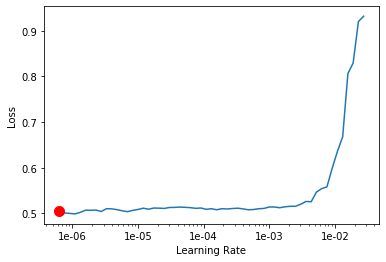

In [0]:
learner.lr_find()
learner.recorder.plot(suggestion=True)
min_grad_lr = learner.recorder.min_grad_lr

In [0]:
learner.fit_one_cycle(1,max_lr=5e-5,moms=(0.8,0.9))

epoch,train_loss,valid_loss,accuracy,accuracy_thresh,multi_label_fbeta,time
0,0.514411,0.514051,0.401633,0.735614,0.651996,00:07


In [0]:
learner.save("xlnet_first")

In [0]:
learner.load("roberta_first")

In [0]:
learner.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-05
Min loss divided by 10: 2.75E-05


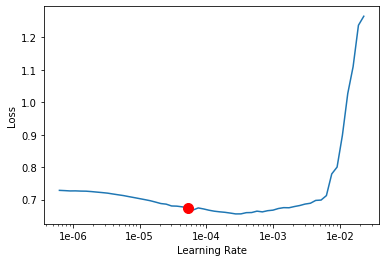

In [0]:
learner.lr_find()
learner.recorder.plot(suggestion=True)
min_grad_lr = learner.recorder.min_grad_lr

In [0]:
learner.fit_one_cycle(1,max_lr=min_grad_lr,moms=(0.8,0.9))

epoch,train_loss,valid_loss,accuracy,accuracy_thresh,multi_label_fbeta,time
0,0.523387,0.503644,0.405521,0.743002,0.661893,00:17


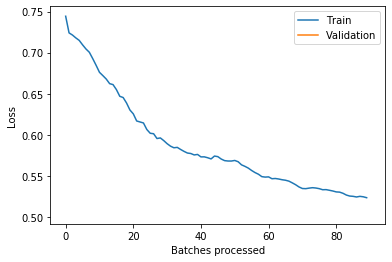

In [0]:
learner.recorder.plot_losses()

In [0]:
learner.save("roberta_sec")

In [0]:
learner.load("roberta_sec")

AttributeError: ignored

In [0]:
learner.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.98E-07


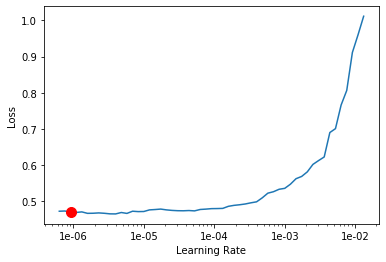

In [0]:
learner.lr_find()
learner.recorder.plot(suggestion=True)
min_grad_lr = learner.recorder.min_grad_lr

In [0]:
learner.fit_one_cycle(1,max_lr=1e-6,moms=(0.8,0.9))

epoch,train_loss,valid_loss,accuracy,accuracy_thresh,multi_label_fbeta,time
0,0.468325,0.506622,0.396967,0.746112,0.671694,00:17


In [0]:
learner.save("xlnet_third_with_wd_smbs")

In [0]:
learner.metrics=[accuracy,accuracy_thresh] #throws error when loading so remove f_beta when loading then add it back
learner.load("xlnet_third_with_wd_smbs")
learner.metrics=[accuracy,accuracy_thresh,f_beta]

#### Train after unfreeze

In [0]:
learner.unfreeze()

In [0]:
learner.lr_find()
learner.recorder.plot(suggestion=True)
min_grad_lr = learner.recorder.min_grad_lr

In [0]:
learner.fit_one_cycle(1,max_lr=1e-5,moms=(0.8,0.9))

In [104]:
learner.fit_one_cycle(5, max_lr=1e-5,moms=(0.8,0.9),callbacks=[SaveModelCallback(learner,every="improvement",monitor="valid_loss",name="uda_pretrained_log")])

epoch,train_loss,valid_loss,accuracy,accuracy_thresh,multi_label_fbeta,cpu used,peak,gpu used,peak,time
0,0.648394,0.543909,0.388414,0.737947,0.682375,20,53,1132,13834,13:53
1,0.595730,0.522705,0.381415,0.732115,0.685532,20,50,0,13782,13:52
2,0.596397,0.517787,0.386858,0.751555,0.668396,20,54,0,13724,13:51
3,0.551665,0.526049,0.393857,0.729393,0.683060,20,52,0,13844,13:56
4,0.531672,0.529591,0.391524,0.735225,0.685160,20,56,0,13840,14:00


| ID | GPU | MEM |
------------------
|  0 | 86% | 33% |
| ID | GPU | MEM |
------------------
|  0 | 53% | 15% |
| ID | GPU | MEM |
------------------
|  0 | 59% | 97% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 15% |
| ID | GPU | MEM |
------------------
|  0 | 46% | 87% |
| ID | GPU | MEM |
------------------
|  0 | 64% | 15% |
| ID | GPU | MEM |
------------------
|  0 | 55% | 80% |
| ID | GPU | MEM |
------------------
|  0 | 52% | 15% |
| ID | GPU | MEM  |
-------------------
|  0 | 60% | 100% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 15% |
| ID | GPU | MEM |
------------------
|  0 | 93% | 95% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 15% |
Better model found at epoch 0 with valid_loss value: 0.5439090132713318.
| ID | GPU | MEM |
------------------
|  0 | 86% | 37% |
| ID | GPU | MEM |
------------------
|  0 | 74% | 15% |
| ID | GPU | MEM |
------------------
|  0 | 89% | 68% |
| ID | GPU | MEM |
------------------
|  0 | 63% | 15% |
| I

In [0]:
learner.recorder.plot_losses()

NameError: ignored

In [0]:
learner.save("xlnet-no-lm-temp")

In [0]:
learner.metrics=[accuracy,accuracy_thresh]
learner.load("uda_log")
learner.metrics=[accuracy,accuracy_thresh,f_beta]

In [0]:
learner.loss_func = nn.BCEWithLogitsLoss()
learner.validate()

[0.5136147, tensor(0.3977), tensor(0.7344), tensor(0.6804, device='cuda:0')]

In [0]:
learner.save("xlnet_clas_no_lm")

In [0]:
del inp,out
gc.collect()
torch.cuda.empty_cache()

In [0]:
!nvidia-smi

Tue Jan  7 02:05:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    34W / 250W |  15181MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:

torch.cuda.empty_cache()
inp,out=databunch.one_batch(cpu=False)
custom_transformer_model.to('cuda')



In [86]:
learner.validate()

[0.5215129, tensor(0.3876), tensor(0.7473), tensor(0.6934, device='cuda:0')]

####Get results

In [105]:
#@title panel
#default activation function is derived from the loss when getting preds
preds,t_labels = learner.get_preds(activ=nn.Sigmoid())
preds,t_labels = preds.numpy(),t_labels.numpy()
thresh = 0.5 #@param
preds[preds >= thresh]=1
preds[preds < thresh]=0
print(classification_report(t_labels,preds,target_names=overall_categories,digits=5))
print(accuracy_score(t_labels,preds))

| ID | GPU | MEM |
------------------
|  0 | 74% | 24% |
| ID | GPU | MEM |
------------------
|  0 | 28% | 15% |
| ID | GPU | MEM |
------------------
|  0 | 32% | 16% |
| ID | GPU | MEM |
------------------
|  0 |  0% | 15% |
| ID | GPU | MEM |
------------------
|  0 |  1% | 15% |
| ID | GPU | MEM |
------------------
|  0 |  0% | 15% |
| ID | GPU | MEM |
------------------
|  0 | 21% | 15% |
| ID | GPU | MEM |
------------------
|  0 |  0% | 15% |
| ID | GPU | MEM |
------------------
|  0 | 12% | 15% |
| ID | GPU | MEM |
------------------
|  0 |  0% | 15% |
| ID | GPU | MEM |
------------------
|  0 | 18% | 15% |
| ID | GPU | MEM |
------------------
|  0 |  0% | 15% |
| ID | GPU | MEM |
------------------
|  0 | 17% | 15% |
| ID | GPU | MEM |
------------------
|  0 |  0% | 15% |
| ID | GPU | MEM |
------------------
|  0 |  0% | 15% |
| ID | GPU | MEM |
------------------
|  0 |  0% | 15% |
| ID | GPU | MEM |
------------------
|  0 | 15% | 15% |
| ID | GPU | MEM |
------------

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


test:
```
              precision    recall  f1-score   support

     support    0.62707   0.67761   0.65136       335
  disclosive    0.65274   0.74184   0.69444       674

   micro avg    0.64450   0.72052   0.68039      1009
   macro avg    0.63991   0.70973   0.67290      1009
weighted avg    0.64422   0.72052   0.68014      1009
 samples avg    0.51166   0.50544   0.49896      1009
```

exp test:  
lr 1e-5
```
              precision    recall  f1-score   support

     support    0.63743   0.65075   0.64402       335
  disclosive    0.67152   0.75223   0.70959       674

   micro avg    0.66089   0.71853   0.68851      1009
   macro avg    0.65448   0.70149   0.67680      1009
weighted avg    0.66020   0.71853   0.68782      1009
 samples avg    0.50583   0.50039   0.49482      1009



epoch	train_loss	valid_loss	accuracy	accuracy_thresh	multi_label_fbeta	cpu used	peak	gpu used	peak	time
0	0.587754	0.605043	0.394635	0.632193	0.579556	10	23	2078	11100	05:07
1	0.515643	0.513940	0.393857	0.736003	0.678352	10	24	0	7010	05:07
2	0.490572	0.511097	0.395412	0.741446	0.689107	10	15	0	12824	05:09
3	0.463927	0.505655	0.398523	0.744946	0.688509	10	23	0	12824	05:09
4	0.455051	0.546510	0.414075	0.727061	0.686607	10	24	0	11298	05:12
5	0.428387	0.557956	0.406299	0.727061	0.649000	10	15	0	9344	05:10
6	0.375686	0.596948	0.417185	0.724339	0.663183	10	23	0	12868	05:11
7	0.348772	0.622854	0.411742	0.722395	0.663208	10	15	0	9334	05:11
8	0.355180	0.644017	0.422628	0.719673	0.659102	10	22	0	11298	05:11
9	0.333153	0.646169	0.417963	0.717729	0.659475	10	23	0	12692	05:12
```

log:  
lr:1e-5  
```

              precision    recall  f1-score   support

     support    0.68038   0.64179   0.66052       335
  disclosive    0.66922   0.77745   0.71929       674

   micro avg    0.67243   0.73241   0.70114      1009
   macro avg    0.67480   0.70962   0.68990      1009
weighted avg    0.67293   0.73241   0.69978      1009
 samples avg    0.50778   0.50855   0.49974      1009

epoch	train_loss	valid_loss	accuracy	accuracy_thresh	multi_label_fbeta	cpu used	peak	gpu used	peak	time
0	0.619644	0.535592	0.393079	0.726672	0.679435	40	75	1132	13850	19:54
1	0.575193	0.508279	0.387636	0.750778	0.692861	20	53	0	13618	19:52
2	0.592565	0.506151	0.386081	0.752722	0.663848	41	75	518	13720	13:48
3	0.575860	0.504516	0.381415	0.749222	0.698739	20	50	0	13662	13:49
4	0.590860	0.501973	0.384526	0.755054	0.701139	20	54	0	13744	13:51
```

exp:  
lr 1e-5
```
              precision    recall  f1-score   support

     support    0.68182   0.62687   0.65319       335
  disclosive    0.65380   0.77893   0.71090       674

   micro avg    0.66157   0.72844   0.69340      1009
   macro avg    0.66781   0.70290   0.68204      1009
weighted avg    0.66310   0.72844   0.69174      1009
 samples avg    0.51089   0.50700   0.50026      1009


 epoch	train_loss	valid_loss	accuracy	accuracy_thresh	multi_label_fbeta	cpu used	peak	gpu used	peak	time
0	0.493801	0.680391	0.396190	0.691291	0.679580	31	62	1132	13784	13:49
1	0.574188	0.663418	0.403966	0.747667	0.673377	20	55	0	13836	13:56
2	0.574881	0.630371	0.393079	0.746112	0.687709	20	52	0	13812	13:53
3	0.593605	0.560605	0.392302	0.749611	0.691571	20	50	0	13818	13:44
4	0.558335	0.521513	0.387636	0.747278	0.693396	20	54	0	13776	13:41
```

#### Without finetune of lm

exp:  
1e-5  
```
              precision    recall  f1-score   support

     support    0.65823   0.62090   0.63902       335
  disclosive    0.66232   0.75371   0.70507       674

   micro avg    0.66113   0.70961   0.68451      1009
   macro avg    0.66027   0.68730   0.67204      1009
weighted avg    0.66096   0.70961   0.68314      1009
 samples avg    0.49806   0.49456   0.48808      1009

epoch	train_loss	valid_loss	accuracy	accuracy_thresh	multi_label_fbeta	cpu used	peak	gpu used	peak	time
0	0.488590	0.675085	0.386081	0.664852	0.645850	20	52	1132	13832	13:53
1	0.558965	0.663746	0.394635	0.741446	0.631579	20	55	0	13796	13:52
2	0.543570	0.636842	0.408631	0.740280	0.607981	20	53	0	13846	13:58
3	0.566829	0.565225	0.398523	0.747667	0.667009	20	51	0	13768	13:48
4	0.550432	0.529440	0.393079	0.743390	0.684512	20	55	0	13830	13:46
```